In [8]:
import torchphysics as tp 
import torch
import pytorch_lightning as pl
# Test to learn integrator f -> u with u' = f (data driven + physics)

T = tp.spaces.R1("t")
U = tp.spaces.R1("u")   
F = tp.spaces.R1("f")

branch_space = tp.spaces.FunctionSpace(T, F)
data_space = branch_space

In [9]:
# create some dummy data:
N_B = 1000
N_branch_grid = 10
branch_params = torch.randn((1000, 1))
branch_grid = torch.linspace(0, 1, N_branch_grid).unsqueeze(0)
branch_input = (branch_params * branch_grid).unsqueeze(-1)
branch_grid = branch_grid.unsqueeze(-1)

N_trunk_grid = 100
trunk_input = torch.linspace(0, 1, N_trunk_grid).unsqueeze(0)
right_hand_side = (branch_params * trunk_input).unsqueeze(-1)
trunk_input = trunk_input.unsqueeze(-1)

print("Shapes of data:")
print("Branch dis. grid:", branch_grid.shape)
print("Branch input:", branch_input.shape)
print("Trunk input:", trunk_input.shape)
print("Right hand side:", right_hand_side.shape)

Shapes of data:
Branch dis. grid: torch.Size([1, 10, 1])
Branch input: torch.Size([1000, 10, 1])
Trunk input: torch.Size([1, 100, 1])
Expected output: torch.Size([1000, 100, 1])


In [10]:
data_functionset = tp.domains.DataFunctionSetDeepONet(
    data_space, branch_space, trunk_input, branch_input,
    branch_discretization_data=branch_grid, parameter_data=right_hand_side, parameter_space=F
)

data_functionsampler = tp.samplers.FunctionSampler(N_B, data_functionset)

In [ ]:
trunk_net = tp.models.FCTrunkNet(T, hidden=(10, 10))
branch_net = tp.models.FCBranchNet(branch_space, hidden=(20, 20), 
                                   discretization_sampler=data_functionset.branch_input_sampler)
model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=20)

In [12]:
def data_residual(u, t, f):
    return tp.utils.grad(u, t) - f

data_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                              function_sampler=data_functionsampler, 
                                              input_sampler=data_functionset.trunk_sampler, 
                                              residual_fn=data_residual)

In [13]:
interval = tp.domains.Interval(T, 0, 1)
boundary_sampler = tp.samplers.RandomUniformSampler(interval.boundary_left, 10)

def initial_residual(u):
    return u

initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                              function_sampler=data_functionsampler, 
                                              input_sampler=boundary_sampler, 
                                              residual_fn=initial_residual)

In [14]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

solver = tp.solver.Solver([data_cond, initial_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False)

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: User

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

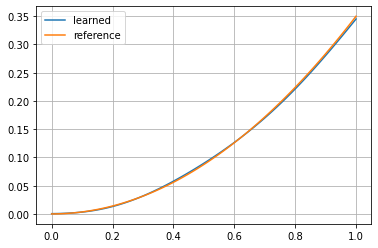

: 

In [17]:
scale = 0.7
test_branch_input = (scale * branch_grid)
test_trunk_input = tp.spaces.Points(trunk_input, T)
model_out = model(test_trunk_input, test_branch_input).as_tensor

import matplotlib.pyplot as plt

plt.plot(test_trunk_input.as_tensor[0], model_out.detach()[0])
plt.plot(test_trunk_input.as_tensor[0], scale/2.0*test_trunk_input.as_tensor[0]**2)
plt.legend(["learned", "reference"])
plt.grid()